* This notebook was to explore the effect of long river on salinity and surface current in the plume.

In [1]:
%matplotlib inline
from matplotlib import pylab
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from salishsea_tools import (viz_tools,tidetools,nc_tools)
import seaborn as sns
import os
import arrow
from datetime import (
    datetime,
    timedelta,)
sns.set_style('darkgrid')

In [2]:
grid6 =nc.Dataset(
        '/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc',
        'r')
grid2 =nc.Dataset(
        '/ocean/jieliu/research/meopar/nemo-forcing/grid/bathy_meter_SalishSea2.nc',
        'r')
grids = [grid2,grid6]
Bathy = grid6.variables['Bathymetry'][:, :]
X = grid6.variables['nav_lon'][:, :]
Y = grid6.variables['nav_lat'][:, :]

In [3]:
runs=['TS2','TS4']
base='/ocean/sallen/allen/research/MEOPAR/myResults/NEMO36_Tides'
depths={};sals={}; Us={}; Vs={}
for run in runs:
    path = os.path.join(base,'{}/SalishSea_1d_20030421_20030530_grid_T.nc'.format(run))
    f = nc.Dataset(path,'r');
    sals[run]=f.variables['vosaline'][:]
    depths[run] = f.variables['deptht'] 
    T_lat = f.variables['nav_lat'][:]
    T_lon = f.variables['nav_lon'][:]
    timesteps = f.variables['time_counter']
    #Loading data on the ugrid
    path = os.path.join(base,'{}/SalishSea_1d_20030421_20030530_grid_U.nc'.format(run))
    f = nc.Dataset(path,'r');
    Us[run]=f.variables['vozocrtx']
    #Loading data on the ugrid
    path = os.path.join(base,'{}/SalishSea_1d_20030421_20030530_grid_V.nc'.format(run))
    f = nc.Dataset(path,'r');
    Vs[run]=f.variables['vomecrty']

In [9]:
def quiver_salinity(t,dep,imin=1,imax=396,jmin=1,jmax=896,st=5,cmin= -4, cmax=4, dels = 0.4):
    "compare rivers and salinity at t, dep in box. st is quiver arrow interval"
    fig,axs = plt.subplots(1,3,figsize=(36,15))
    x=np.arange(imin,imax)
    y=np.arange(jmin,jmax)
    U={}; V={};u={};v={};uE={};vN={};
    for key, ax,grid in zip(runs,axs[:-1],grids):
        #truncate U/V and unstagger
        U[key]= Us[key][t,dep,jmin-1:jmax,imin-1:imax]
        V[key] =Vs[key][t,dep,jmin-1:jmax,imin-1:imax]
        lon=T_lon[jmin:jmax,imin:imax]
        lat=T_lat[jmin:jmax,imin:imax]
        S=sals[key][t,dep,jmin:jmax,imin:imax]
        S = np.ma.masked_values(S, 0)
        #masking
        U[key] = np.ma.masked_values(U[key],0)
        V[key] = np.ma.masked_values(V[key],0)
        #unstagger
        u[key],v[key] = viz_tools.unstagger(U[key],V[key])
        #rotate
        theta = np.pi*29/180
        uE[key] = u[key]*np.cos(theta) - v[key]*np.sin(theta)
        vN[key] = u[key]*np.sin(theta) +v[key]*np.cos(theta)
        #mesh
        mesh=ax.pcolormesh(lon,lat,S,cmap='spectral')
        viz_tools.plot_land_mask(ax,grid,coords='map',color='burlywood')
        #quivers
        quiver = ax.quiver(lon[::st,::st],lat[::st,::st],uE[key][::st,::st], vN[key][::st,::st],
                       pivot='mid', scale = 5, color='white',width=0.005
                       )
        ax.quiverkey(quiver,-123.9,49., 1,'1 m/s',coordinates='data', color='black', labelcolor='black',\
                    fontproperties = {'size': '15'})
        cbar = plt.colorbar(mesh,ax=ax)
        plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)
        cbar.set_label('Practical Salinity',fontsize = 20)
        ax.plot((-123.1,-123.8),(49,49.2),'k-')
        ax.set_xlim([-124.,-123])
        ax.set_ylim([48.9,49.4])
        plt.setp(ax.get_xticklabels(), fontsize=20)
        plt.setp(ax.get_yticklabels(), fontsize=20)
        ax.set_title(key, fontsize = 20)       
    ##plot difference
    ax = axs[-1]
    sal_diff = sals[runs[1]][t,dep,jmin:jmax,imin:imax] - sals[runs[0]][t,dep,jmin:jmax,imin:imax]
    U_diff = uE[runs[0]] - uE[runs[1]]
    V_diff = vN[runs[0]] - vN[runs[1]]
    mesh=ax.pcolormesh(lon,lat,sal_diff,cmap='RdBu_r',vmin=cmin, vmax=cmax)
    quiver = ax.quiver(lon[::st,::st], lat[::st,::st],U_diff[ ::st, ::st], V_diff[::st,::st],\
                           pivot='mid',scale=5, width=0.005, color='black' )
    ax.quiverkey(quiver,-123.9,49., 1, '1 m/s',
                        coordinates='data', color='black', labelcolor='black',
                    fontproperties = {'size': '15'})
    viz_tools.plot_land_mask(ax,grid,coords='map',xslice=x,yslice=y,color='burlywood')
    cbar = plt.colorbar(mesh, ax=ax)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)
    cbar.set_label(' Salinity difference',fontsize = 20)
    ax.plot((-123.1,-123.8),(49,49.2),'k-')
    plt.setp(ax.get_xticklabels(), fontsize=20)
    plt.setp(ax.get_yticklabels(), fontsize=20)
    ax.set_title('difference between TS2 & TS4',\
                     fontsize = 20)
    ax.set_xlim([-124.,-123])
    ax.set_ylim([48.9,49.4])
    return fig  

In [5]:
def time_origin(dataset):
    """Return the time_counter.time_origin value.

    :arg dataset: netcdf dataset object
    :type dataset: :py:class:`netCDF4.Dataset`

    :returns: Value of the time_origin attribute of the time_counter
              variable.
    :rtype: :py:class:`Arrow` instance
    """
    try:
        time_counter = dataset.variables['time_counter']
    except KeyError:
        raise KeyError('dataset does not have time_counter variable')
    try:
        time_origin = time_counter.time_origin.title()
    except AttributeError:
        raise AttributeError(
            'NetCDF: '
            'time_counter variable does not have time_origin attribute')
    value = arrow.get(time_origin, 'YYYY-MM-DD HH:mm:ss')
    return value

In [6]:
def timestamp(dataset, tindex):
    """Return the time stamp of the tindex time_counter value(s) in dataset.

    The time stamp is calculated by adding the time_counter[tindex] value
    (in seconds) to the dataset's time_counter.time_origin value.

    :arg dataset: netcdf dataset object
    :type dataset: :py:class:`netCDF4.Dataset`

    :arg tindex: time_counter variable index.
    :type tindex: int or list

    :returns: Time stamp value(s) at tindex in the dataset.
    :rtype: :py:class:`Arrow` instance or list of instances
    """
    time_orig = time_origin(dataset)
    time_counter = dataset.variables['time_counter']
    try:
        iter(tindex)
    except TypeError:
        tindex = [tindex]
    results = []
    for i in tindex:
        try:
            results.append(time_orig + timedelta(seconds=time_counter[i]))
        except IndexError:
            raise IndexError(
                'time_counter variable has no tindex={}'.format(tindex))
    if len(results) > 1:
        return results
    else:
        return results[0]

In [7]:
def salinity_transect_plot(t,dep):
    slats = np.linspace(49, 49.2, num=30, endpoint=True)
    slons = np.linspace(-123.1,-123.8, num=30, endpoint=True)
    ylat = np.zeros((30), dtype=np.int64)
    xlon = np.zeros((30), dtype=np.int64)
    for i, lat in enumerate(slats):
        lon = slons[i]
        ylat[i], xlon[i] = tidetools.find_closest_model_point(lon, lat, X, Y, Bathy, lat_tol=0.003)
    sals_0 = np.ma.masked_values(sals[runs[0]][t,dep], 0)
    sals_1 = np.ma.masked_values(sals[runs[1]][t,dep], 0)
    fig,ax = plt.subplots(1,1,figsize=(8,6))
    ax.plot(slons, sals_0[ ylat, xlon], 'b*-',label = runs[0]);
    ax.plot(slons, sals_1[ ylat, xlon], 'go-',label = runs[1]);
    ax.legend(loc ='best', fontsize = 15)
    ax.set_xlim((-124,-123))
    ax.set_ylim((0,30))
    ax.set_xlabel('longitude [degree]')
    ax.set_ylabel('Practical Salinity')
    return fig

In [8]:
def min_sal(dep):
    """To plot min salinity value and location of a fixed depth"""
    min_sals = {runs[0]:[],runs[1]:[]};min_lons = {runs[0]:[],runs[1]:[]};
    slats = np.linspace(49, 49.2, num=30, endpoint=True)
    slons = np.linspace(-123.1,-123.8, num=30, endpoint=True)
    ylat = np.zeros((30), dtype=np.int64)
    xlon = np.zeros((30), dtype=np.int64)
    for i, lat in enumerate(slats):
        lon = slons[i]
        ylat[i], xlon[i] = tidetools.find_closest_model_point(lon, lat, X, Y, Bathy, lat_tol=0.003)
    T_lon_zoomin = T_lon[ylat,xlon];
    for run in runs:
        for t in np.arange(len(timesteps)):
            sal = np.ma.masked_values(sals[run][t,dep,ylat,xlon], 0)
            i = np.where(sal == np.nanmin(sal))
            min_sals[run].append(np.nanmin(sal))
            min_lons[run].append(T_lon_zoomin[i])
    ## for time t
    path = os.path.join(base,'{}/SalishSea_1d_20030421_20030530_grid_T.nc'.format(runs[0]))
    f = nc.Dataset(path,'r');
    t_t = timestamp(f, np.arange(len(timesteps)))
    for ind in range(len(t_t)):
        t_t[ind] = t_t[ind].datetime
    tt = np.array(t_t)   
    ##plot
    fig, axs = plt.subplots(2,1,figsize = [8,8])
    combines = [min_sals,min_lons];
    for ax, combine in zip(axs, combines):
        ax.plot(tt,combine[runs[0]], 'b^-',label = runs[0])
        ax.plot(tt,combine[runs[1]],'r*-',label = runs[1])
        ax.legend(loc = 'best')
    return fig

# Surface layer

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


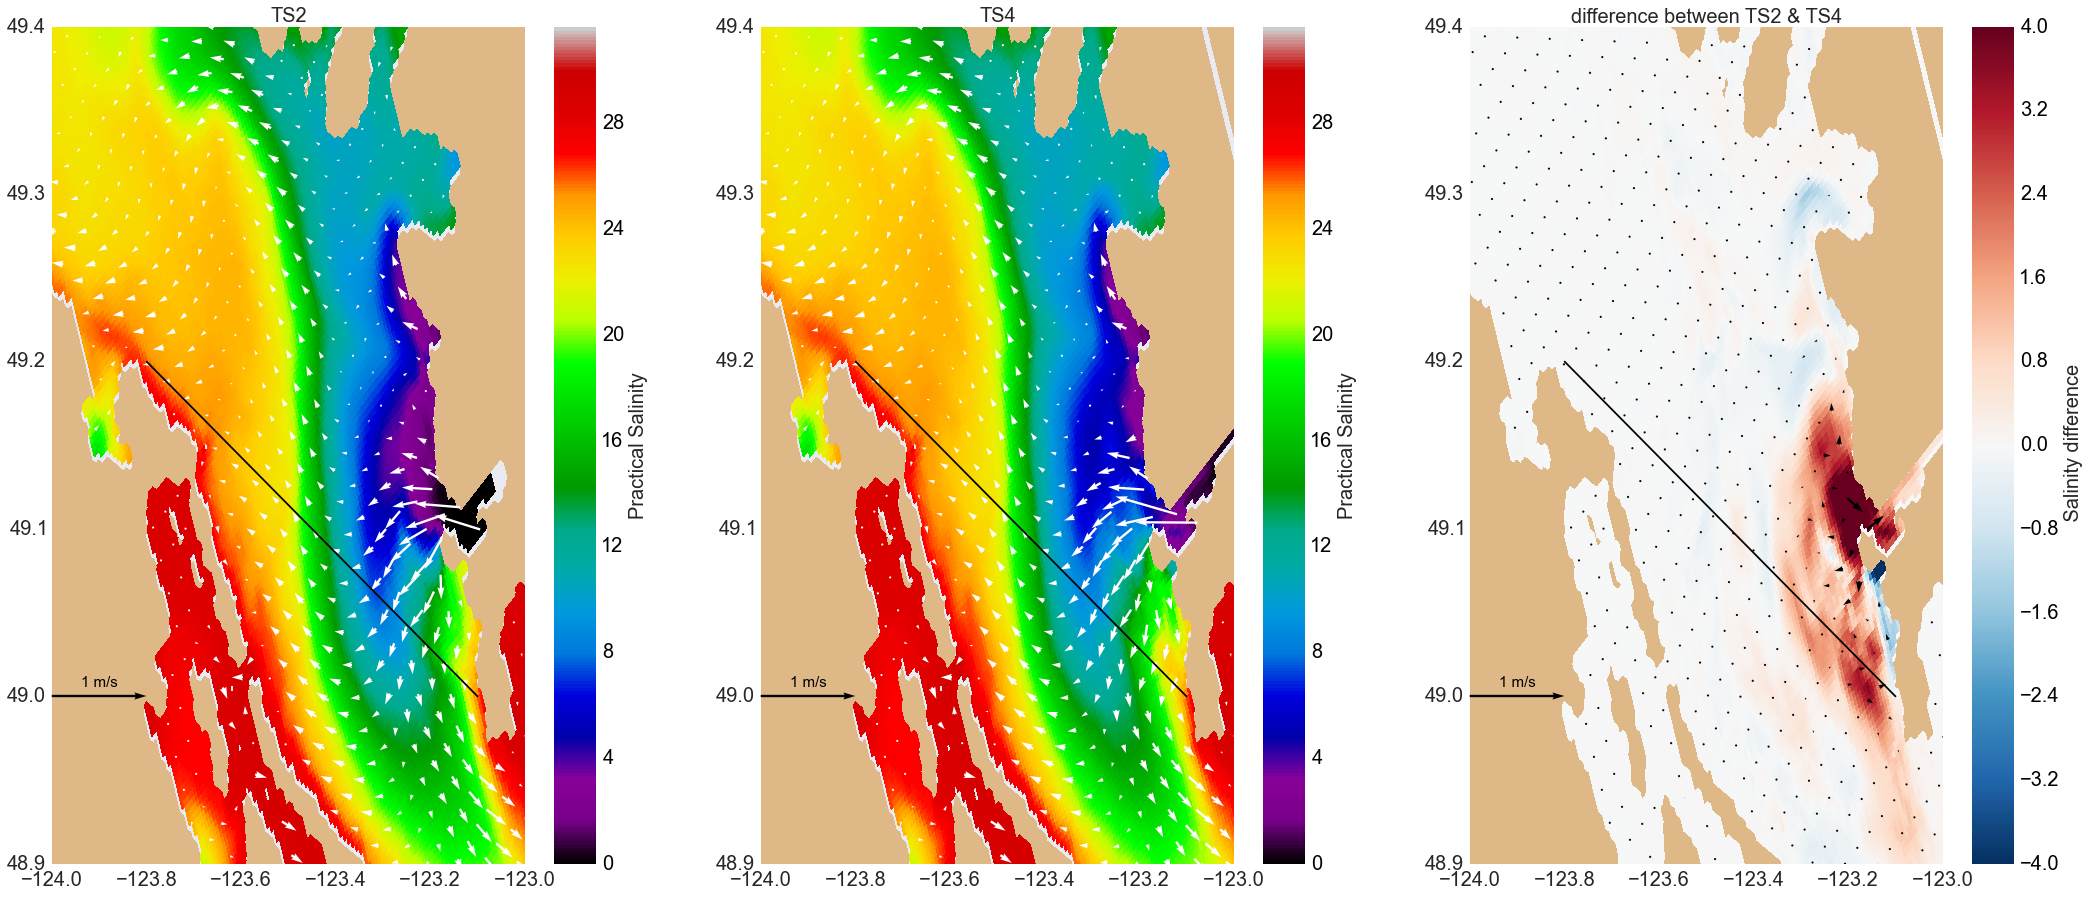

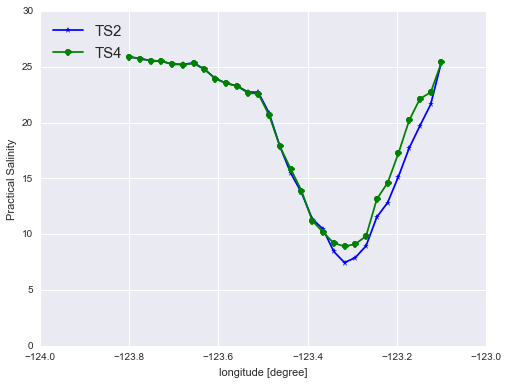

In [10]:
## start day & surface currents
t=0; dep=0
fig=quiver_salinity(t,dep)
fig = salinity_transect_plot(t,dep)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


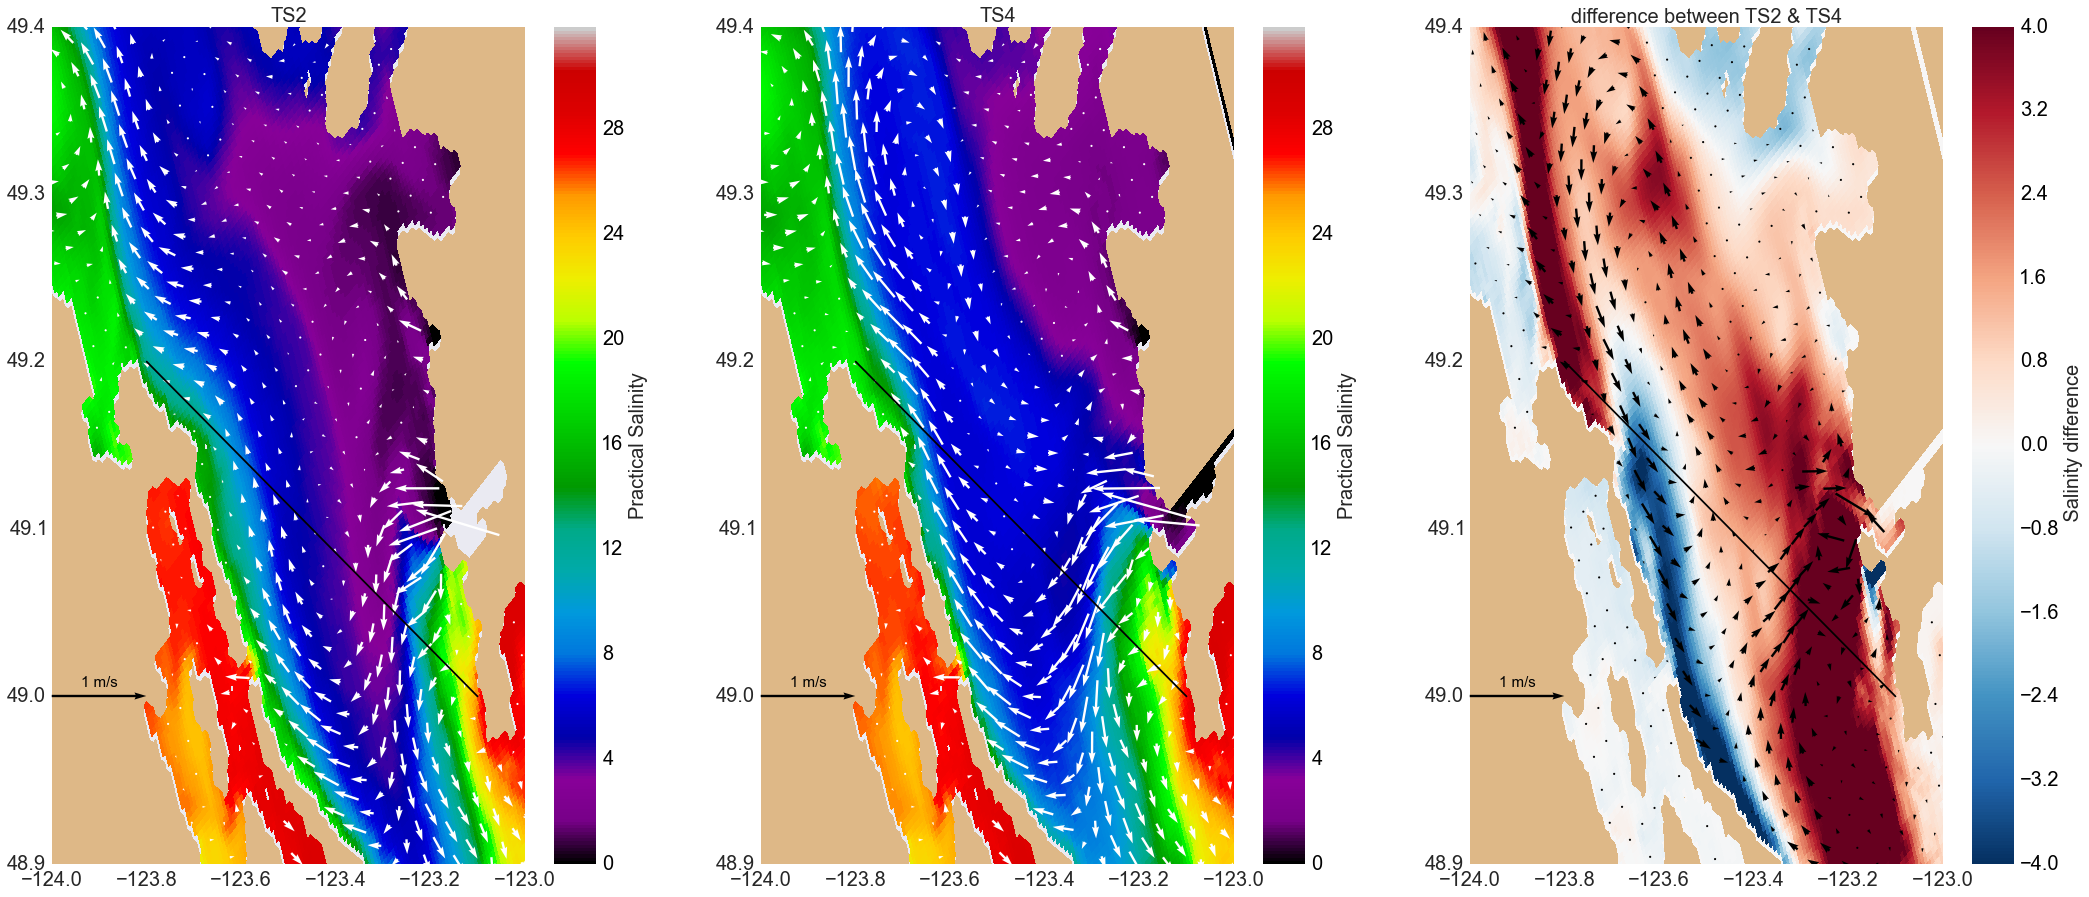

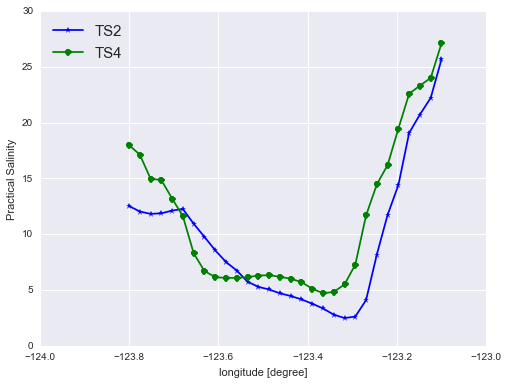

In [11]:
## end of this period & surface currents
t=39; dep=0
fig=quiver_salinity(t,dep)
fig = salinity_transect_plot(t,dep)

# 1.5m

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


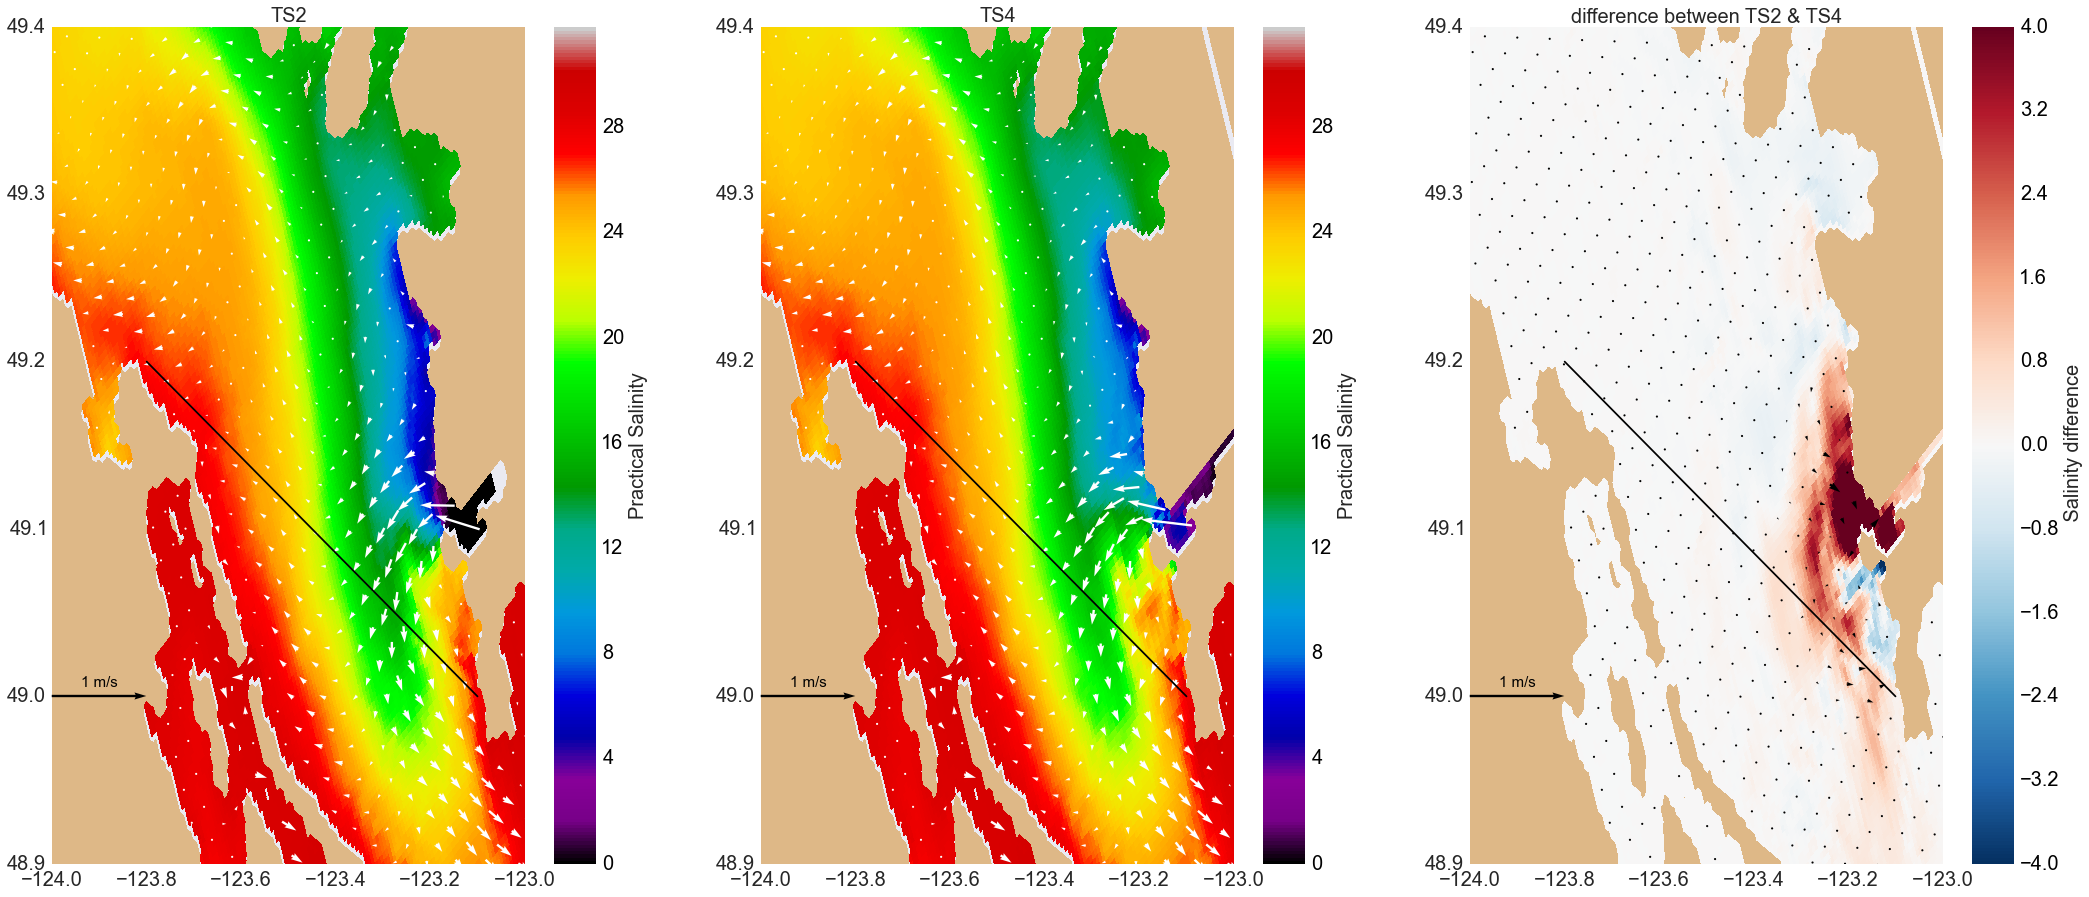

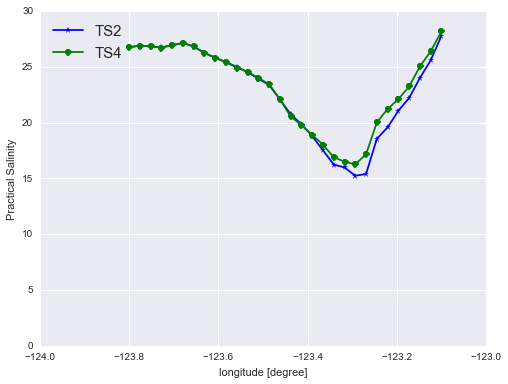

In [12]:
## start day & 1.5m 
t=0; dep=1
fig=quiver_salinity(t,dep)
fig = salinity_transect_plot(t,dep)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


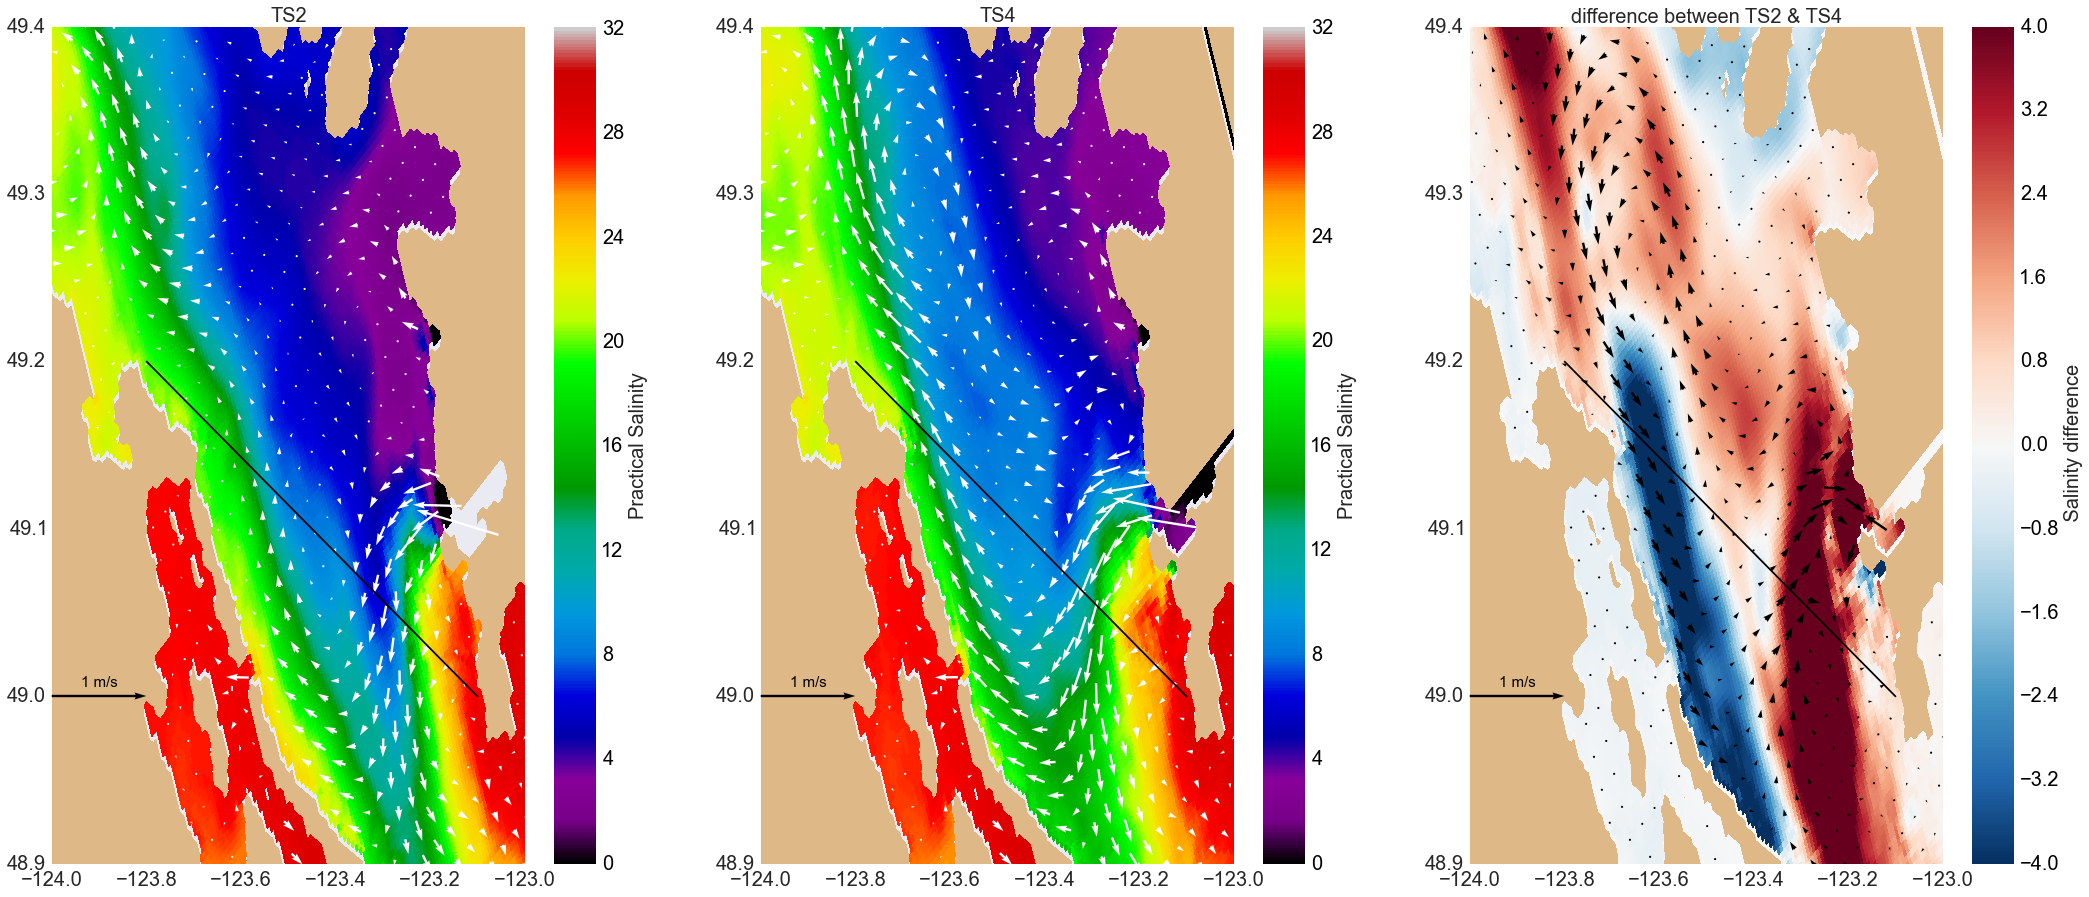

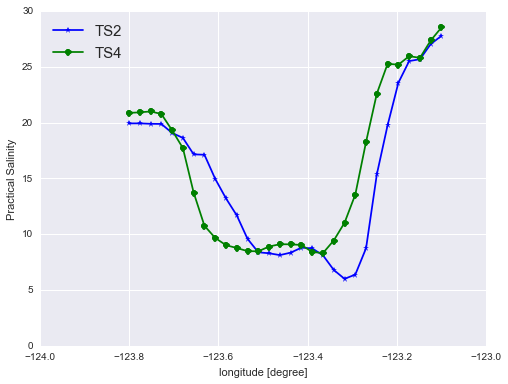

In [13]:
t=39; dep=1
fig=quiver_salinity(t,dep)
fig = salinity_transect_plot(t,dep)

# Minimum salinity value, location

* surface layer

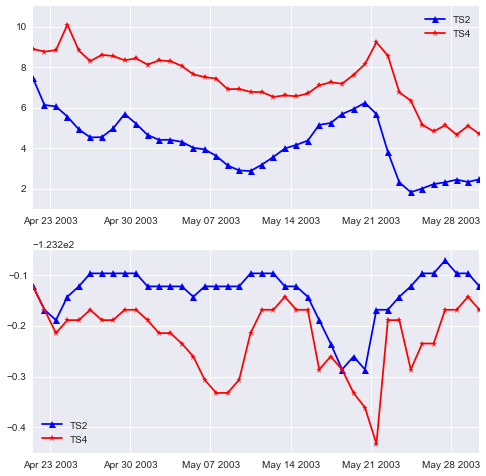

In [14]:
fig = min_sal(0)

* 1.5 m

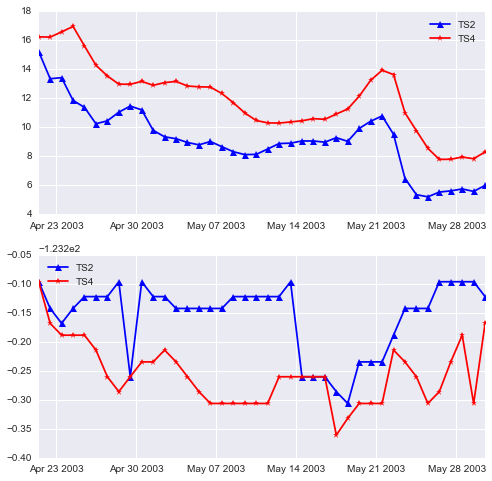

In [15]:
fig = min_sal(1)